In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from collections import defaultdict
from wordcloud import WordCloud
import nltk
import spacy
from nltk.stem import PorterStemmer
from gensim.parsing.preprocessing import STOPWORDS
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 10]



from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity


import pickle
import kaggle
from zipfile import ZipFile
import warnings
warnings.filterwarnings("ignore")

In [2]:
# !kaggle datasets download -d hernan4444/anime-recommendation-database-2020

In [3]:
# file_name = r'anime-recommendation-database-2020.zip'
# with ZipFile(file_name, 'r') as zip:
#     zip.extractall()
#     print('Done')

In [4]:
# Anime data
columns = ['MAL_ID', 'Name', 'Genres', 'Type', 'Type', 'Aired', 'Premiered', 'Producers', 'Licensors', 'Studios', 'Source', 'Duration', 'Rating', 'Popularity', 'Score', 'Episodes']
anime_data = pd.read_csv('anime.csv', usecols=columns)
# Synopsis data
synopsis = pd.read_csv('anime_with_synopsis.csv')

In [5]:
anime_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17562 entries, 0 to 17561
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   MAL_ID      17562 non-null  int64 
 1   Name        17562 non-null  object
 2   Score       17562 non-null  object
 3   Genres      17562 non-null  object
 4   Type        17562 non-null  object
 5   Episodes    17562 non-null  object
 6   Aired       17562 non-null  object
 7   Premiered   17562 non-null  object
 8   Producers   17562 non-null  object
 9   Licensors   17562 non-null  object
 10  Studios     17562 non-null  object
 11  Source      17562 non-null  object
 12  Duration    17562 non-null  object
 13  Rating      17562 non-null  object
 14  Popularity  17562 non-null  int64 
dtypes: int64(2), object(13)
memory usage: 2.0+ MB


In [6]:
synopsis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16214 entries, 0 to 16213
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   MAL_ID     16214 non-null  int64 
 1   Name       16214 non-null  object
 2   Score      16214 non-null  object
 3   Genres     16214 non-null  object
 4   sypnopsis  16206 non-null  object
dtypes: int64(1), object(4)
memory usage: 633.5+ KB


In [7]:
anime_data = anime_data[anime_data['Type'] == 'TV']

full_anime_data = anime_data.merge(synopsis)
full_anime_data = full_anime_data.rename(columns={'sypnopsis': 'Synopsis'})

In [8]:
full_anime_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4996 entries, 0 to 4995
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   MAL_ID      4996 non-null   int64 
 1   Name        4996 non-null   object
 2   Score       4996 non-null   object
 3   Genres      4996 non-null   object
 4   Type        4996 non-null   object
 5   Episodes    4996 non-null   object
 6   Aired       4996 non-null   object
 7   Premiered   4996 non-null   object
 8   Producers   4996 non-null   object
 9   Licensors   4996 non-null   object
 10  Studios     4996 non-null   object
 11  Source      4996 non-null   object
 12  Duration    4996 non-null   object
 13  Rating      4996 non-null   object
 14  Popularity  4996 non-null   int64 
 15  Synopsis    4991 non-null   object
dtypes: int64(2), object(14)
memory usage: 663.5+ KB


In [9]:
full_anime_data['Synopsis'] = full_anime_data['Synopsis'].dropna()

In [10]:
full_anime_data.isna().sum()

MAL_ID        0
Name          0
Score         0
Genres        0
Type          0
Episodes      0
Aired         0
Premiered     0
Producers     0
Licensors     0
Studios       0
Source        0
Duration      0
Rating        0
Popularity    0
Synopsis      5
dtype: int64

In [11]:
full_anime_data.head()

,MAL_ID,Name,Score,Genres,Type,Episodes,Aired,Premiered,Producers,Licensors,Studios,Source,Duration,Rating,Popularity,Synopsis
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,Bandai Visual,"Funimation, Bandai Entertainment",Sunrise,Original,24 min. per ep.,R - 17+ (violence & profanity),39,"In the year 2071, humanity has colonized several of the planets and moons of the solar system leaving the now uninhabitable surface of planet Earth behind. The Inter Solar System Police attempts to keep peace in the galaxy, aided in part by outlaw bounty hunters, referred to as ""Cowboys."" The ragtag team aboard the spaceship Bebop are two such individuals. Mellow and carefree Spike Spiegel is balanced by his boisterous, pragmatic partner Jet Black as the pair makes a living chasing bounties and collecting rewards. Thrown off course by the addition of new members that they meet in their travels—Ein, a genetically engineered, highly intelligent Welsh Corgi; femme fatale Faye Valentine, an enigmatic trickster with memory loss; and the strange computer whiz kid Edward Wong—the crew embarks on thrilling adventures that unravel each member's dark and mysterious past little by little. Well-balanced with high density action and light-hearted comedy, Cowboy Bebop is a space Western classic and an homage to the smooth and improvised music it is named after."
1,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",TV,26,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,Victor Entertainment,"Funimation, Geneon Entertainment USA",Madhouse,Manga,24 min. per ep.,PG-13 - Teens 13 or older,201,"Vash the Stampede is the man with a $$60,000,000,000 bounty on his head. The reason: he's a merciless villain who lays waste to all those that oppose him and flattens entire cities for fun, garnering him the title ""The Humanoid Typhoon."" He leaves a trail of death and destruction wherever he goes, and anyone can count themselves dead if they so much as make eye contact—or so the rumors say. In actuality, Vash is a huge softie who claims to have never taken a life and avoids violence at all costs. With his crazy doughnut obsession and buffoonish attitude in tow, Vash traverses the wasteland of the planet Gunsmoke, all the while followed by two insurance agents, Meryl Stryfe and Milly Thompson, who attempt to minimize his impact on the public. But soon, their misadventures evolve into life-or-death situations as a group of legendary assassins are summoned to bring about suffering to the trio. Vash's agonizing past will be unraveled and his morality and principles pushed to the breaking point."
2,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, Magic",TV,26,"Jul 2, 2002 to Dec 24, 2002",Summer 2002,"TV Tokyo, Bandai Visual, Dentsu, Victor Entertainment","Funimation, Bandai Entertainment",Sunrise,Original,25 min. per ep.,PG-13 - Teens 13 or older,1467,"ches are individuals with special powers like ESP, telekinesis, mind control, etc. Robin, a 15-year-old craft user, arrives from Italy to Japan to work for an organization named STN Japan Division (STN-J) as a replacement for one of STN-J's witch hunters who was recently killed. Unlike other divisions of STN, STN-J tries to capture the witches alive in order to learn why and how they became witches in the first place. (Source: ANN)"
3,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",TV,52,"Sep 30, 2004 to Sep 29, 2005",Fall 2004,"TV Tokyo, Dentsu",Unknown,Toei Animation,Manga,23 min. per ep.,PG - Children,4369,"It is the dark century and the people are suffering under the rule of the devil, Vandel, who is able to manipulate monsters. The Vandel Busters are a group of people who hunt these devils, and among them, the Zenon Squad is known to be the strongest busters on the continent. A young boy, Beet, dreams of joining the Zenon Squad. However, one day, as a result of Beet's fault, the Zenon squad was def

In [12]:
# Top 10 Most Popular Anime & other features
top_rated = full_anime_data.sort_values('Popularity')
popularity = top_rated.head(10)
popularity.head(10)

,MAL_ID,Name,Score,Genres,Type,Episodes,Aired,Premiered,Producers,Licensors,Studios,Source,Duration,Rating,Popularity,Synopsis
690,1535,Death Note,8.63,"Mystery, Police, Psychological, Supernatural, Thriller, Shounen",TV,37,"Oct 4, 2006 to Jun 27, 2007",Fall 2006,"VAP, Konami, Ashi Production, Nippon Television Network, Shueisha",VIZ Media,Madhouse,Manga,23 min. per ep.,R - 17+ (violence & profanity),1,"shinigami, as a god of death, can kill any person—provided they see their victim's face and write their victim's name in a notebook called a Death Note. One day, Ryuk, bored by the shinigami lifestyle and interested in seeing how a human would use a Death Note, drops one into the human realm. High school student and prodigy Light Yagami stumbles upon the Death Note and—since he deplores the state of the world—tests the deadly notebook by writing a criminal's name in it. When the criminal dies immediately following his experiment with the Death Note, Light is greatly surprised and quickly recognizes how devastating the power that has fallen into his hands could be. With this divine capability, Light decides to extinguish all criminals in order to build a new world where crime does not exist and people worship him as a god. Police, however, quickly discover that a serial killer is targeting criminals and, consequently, try to apprehend the culprit. To do this, the Japanese investigators count on the assistance of the best detective in the world: a young and eccentric man known only by the name of L."
2570,16498,Shingeki no Kyojin,8.48,"Action, Military, Mystery, Super Power, Drama, Fantasy, Shounen",TV,25,"Apr 7, 2013 to Sep 29, 2013",Spring 2013,"Production I.G, Dentsu, Mainichi Broadcasting System, Pony Canyon, Kodansha, Mad Box, Pony Canyon Enterprise",Funimation,Wit Studio,Manga,24 min. per ep.,R - 17+ (violence & profanity),2,"Centuries ago, mankind was slaughtered to near extinction by monstrous humanoid creatures called titans, forcing humans to hide in fear behind enormous concentric walls. What makes these giants truly terrifying is that their taste for human flesh is not born out of hunger but what appears to be out of pleasure. To ensure their survival, the remnants of humanity began living within defensive barriers, resulting in one hundred years without a single titan encounter. However, that fragile calm is soon shattered when a colossal titan manages to breach the supposedly impregnable outer wall, reigniting the fight for survival against the man-eating abominations. After witnessing a horrific personal loss at the hands of the invading creatures, Eren Yeager dedicates his life to their eradication by enlisting into the Survey Corps, an elite military unit that combats the merciless humanoids outside the protection of the walls. Based on Hajime Isayama's award-winning manga, Shingeki no Kyojin follows Eren, along with his adopted sister Mikasa Ackerman and his childhood friend Armin Arlert, as they join the brutal war against the titans and race to discover a way of defeating them before the last walls are breached."
1603,5114,Fullmetal Alchemist: Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen",TV,64,"Apr 5, 2009 to Jul 4, 2010",Spring 2009,"Aniplex, Square Enix, Mainichi Broadcasting System, Studio Moriken","Funimation, Aniplex of America",Bones,Manga,24 min. per ep.,R - 17+ (violence & profanity),3,"""In order for something to be obtained, something of equal value must be lost."" Alchemy is bound by this Law of Equivalent Exchange—something the young brothers Edward and Alphonse Elric only realize after attempting human transmutation: the one forbidden act of alchemy. They pay a terrible price for their transgression—Edward loses his left leg, Alphonse his physical body. It is only by the desperate sacrifice of Edward's right arm that he is able to affix Alphonse's soul to a suit of armor. Devastated and alone, it is the hope that they would both eventually return to their 

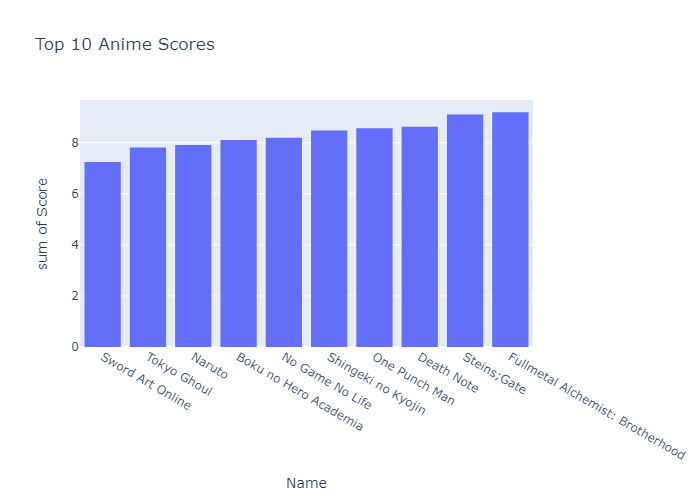

In [13]:
fig = px.histogram(popularity, x ='Name', y='Score', title='Top 10 Anime Scores').update_xaxes(categoryorder='total ascending')
fig.show("png")

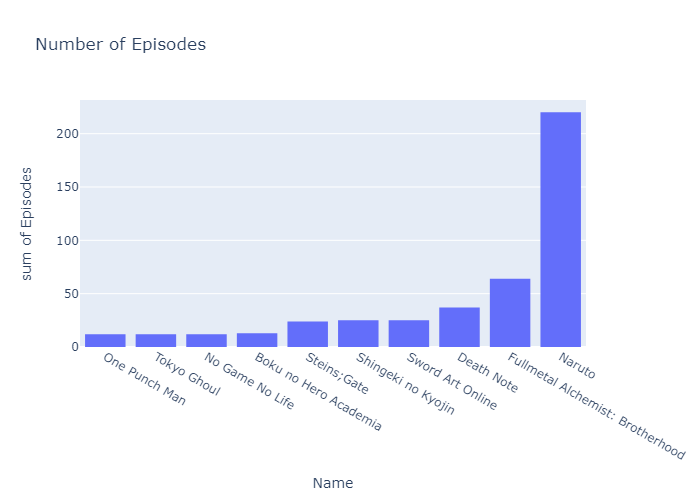

In [14]:
fig = px.histogram(popularity, x='Name', y = 'Episodes', title='Number of Episodes').update_xaxes(categoryorder='total ascending')
fig.show("png")

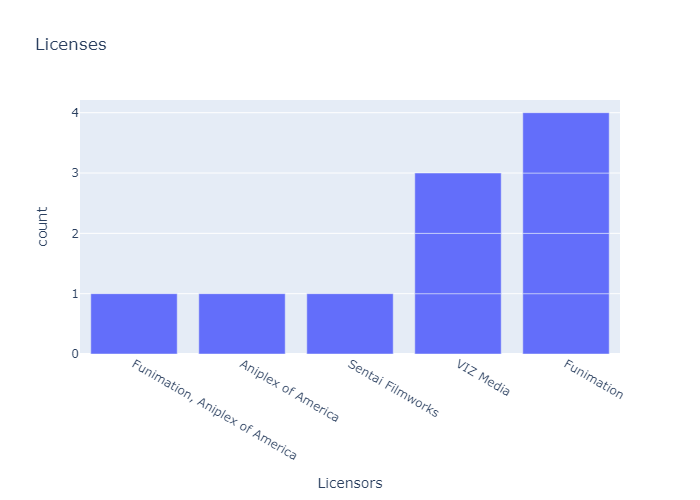

In [15]:
fig = px.bar(popularity, x='Licensors', title='Licenses').update_xaxes(categoryorder='total ascending')
fig.show("png")

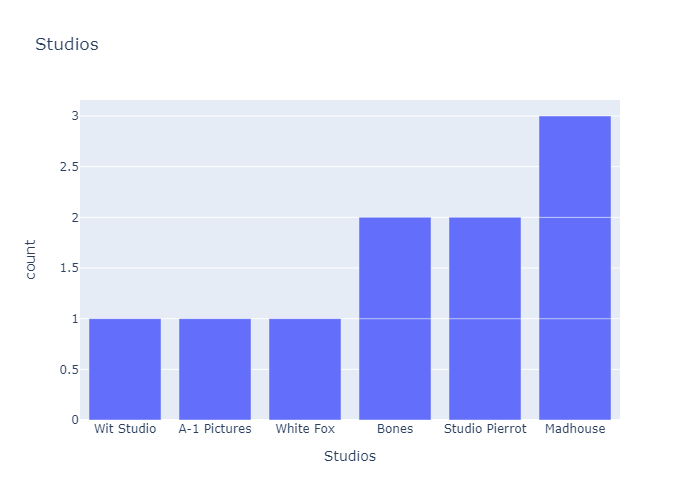

In [16]:
fig = px.bar(popularity, x='Studios', title='Studios').update_xaxes(categoryorder='total ascending')
fig.show("png")

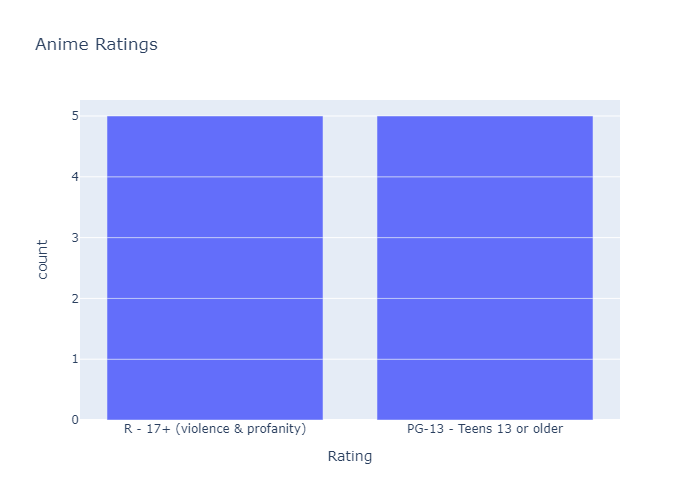

In [17]:
fig = px.bar(popularity, x='Rating', title="Anime Ratings").update_xaxes(categoryorder='total ascending')
fig.show("png")

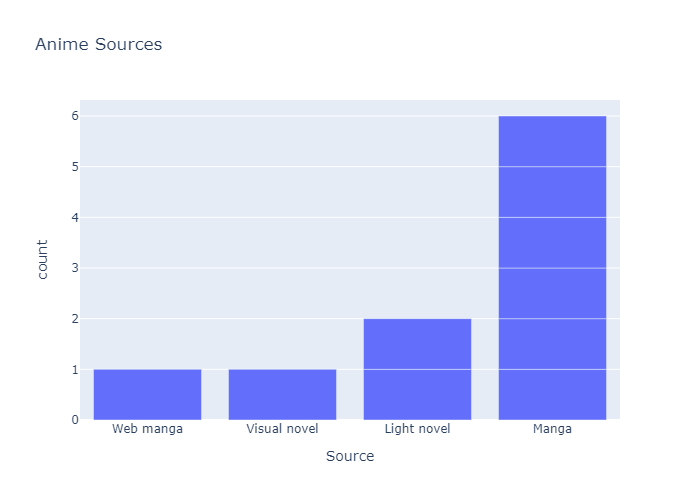

In [18]:
fig = px.bar(popularity, x='Source', title='Anime Sources').update_xaxes(categoryorder='total ascending')
fig.show("png")

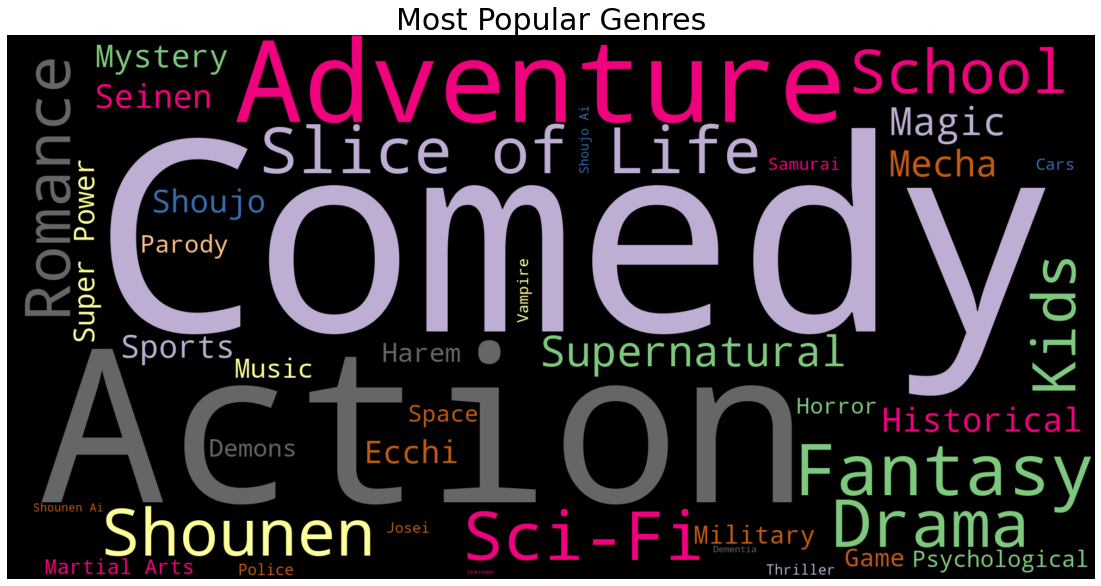

In [19]:
anime_data1 = full_anime_data.copy()

all_genres = defaultdict(int)

for genres in anime_data1['Genres']:
    for genre in genres.split(','):
        all_genres[genre.strip()] += 1

genres_cloud = WordCloud(width=2000, height=1000, background_color='black', colormap='Accent').generate_from_frequencies(all_genres)
plt.imshow(genres_cloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Popular Genres',fontsize = 30)
plt.show("png");

In [20]:
def convert(words):
    
    new_words = words.split(',')
    
    return new_words

In [21]:
full_anime_data['Genres'] = full_anime_data['Genres'].apply(convert)
full_anime_data['Aired'] = full_anime_data['Aired'].apply(convert)
full_anime_data['Premiered'] = full_anime_data['Premiered'].apply(convert)
full_anime_data['Producers'] = full_anime_data['Producers'].apply(convert)
full_anime_data['Licensors'] = full_anime_data['Licensors'].apply(convert)
full_anime_data['Studios'] = full_anime_data['Studios'].apply(convert)
full_anime_data['Source'] = full_anime_data['Source'].apply(convert)
full_anime_data['Duration'] = full_anime_data['Duration'].apply(convert)
full_anime_data['Rating'] = full_anime_data['Rating'].apply(convert)
full_anime_data['Synopsis'] = full_anime_data['Synopsis'].astype(str).apply(convert)

full_anime_data['tags'] = full_anime_data['Genres'] + full_anime_data['Aired'] + full_anime_data['Premiered'] + full_anime_data['Producers'] + full_anime_data['Licensors'] + full_anime_data['Studios'] + full_anime_data['Source'] + full_anime_data['Duration'] + full_anime_data['Rating'] + full_anime_data['Synopsis']

In [22]:
new_data = full_anime_data[['MAL_ID', 'Name', 'tags']]

In [23]:
new_data['tags'] = new_data['tags'].apply(lambda x: " ".join(x))
new_data['tags'] = new_data['tags'].apply(lambda x: x.lower())

In [24]:
new_data.head()

,MAL_ID,Name,tags
0,1,Cowboy Bebop,"action adventure comedy drama sci-fi space apr 3 1998 to apr 24 1999 spring 1998 bandai visual funimation bandai entertainment sunrise original 24 min. per ep. r - 17+ (violence & profanity) in the year 2071 humanity has colonized several of the planets and moons of the solar system leaving the now uninhabitable surface of planet earth behind. the inter solar system police attempts to keep peace in the galaxy aided in part by outlaw bounty hunters referred to as ""cowboys."" the ragtag team aboard the spaceship bebop are two such individuals. mellow and carefree spike spiegel is balanced by his boisterous pragmatic partner jet black as the pair makes a living chasing bounties and collecting rewards. thrown off course by the addition of new members that they meet in their travels—ein a genetically engineered highly intelligent welsh corgi; femme fatale faye valentine an enigmatic trickster with memory loss; and the strange computer whiz kid edward wong—the crew embarks on thrilling adventures that unravel each member's dark and mysterious past little by little. well-balanced with high density action and light-hearted comedy cowboy bebop is a space western classic and an homage to the smooth and improvised music it is named after."
1,6,Trigun,"action sci-fi adventure comedy drama shounen apr 1 1998 to sep 30 1998 spring 1998 victor entertainment funimation geneon entertainment usa madhouse manga 24 min. per ep. pg-13 - teens 13 or older vash the stampede is the man with a $$60 000 000 000 bounty on his head. the reason: he's a merciless villain who lays waste to all those that oppose him and flattens entire cities for fun garnering him the title ""the humanoid typhoon."" he leaves a trail of death and destruction wherever he goes and anyone can count themselves dead if they so much as make eye contact—or so the rumors say. in actuality vash is a huge softie who claims to have never taken a life and avoids violence at all costs. with his crazy doughnut obsession and buffoonish attitude in tow vash traverses the wasteland of the planet gunsmoke all the while followed by two insurance agents meryl stryfe and milly thompson who attempt to minimize his impact on the public. but soon their misadventures evolve into life-or-death situations as a group of legendary assassins are summoned to bring about suffering to the trio. vash's agonizing past will be unraveled and his morality and principles pushed to the breaking point."
2,7,Witch Hunter Robin,action mystery police supernatural drama magic jul 2 2002 to dec 24 2002 summer 2002 tv tokyo bandai visual dentsu victor entertainment funimation bandai entertainment sunrise original 25 min. per ep. pg-13 - teens 13 or older ches are individuals with special powers like esp telekinesis mind control etc. robin a 15-year-old craft user arrives from italy to japan to work for an organization named stn japan division (stn-j) as a replacement for one of stn-j's witch hunters who was recently killed. unlike other divisions of stn stn-j tries to capture the witches alive in order to learn why and how they became witches in the first place. (source: ann)
3,8,Bouken Ou Beet,adventure fantasy shounen supernatural sep 30 2004 to sep 29 2005 fall 2004 tv tokyo dentsu unknown toei animation manga 23 min. per ep. pg - children it is the dark century and the people are suffering under the rule of the devil vandel who is able to manipulate monsters. the vandel busters are a group of people who hunt these devils and among them the zenon squad is known to be the strongest busters on the continent. a young boy beet dreams of joining the zenon squad. however one day as a result of beet's fault the zenon squad was defeated by the devil beltose. the five dying busters sacrificed their life power into their five weapons saiga. after giving their weapons to beet they passed away. years have passed since then and the young vandel buster beet begins his adventure to carry out the 

In [25]:
ps = PorterStemmer()

def stem(text):
    y = []
    
    for i in text.split():
        y.append(ps.stem(i))
        
    return " ".join(y)

In [26]:
new_data['tags'] = new_data['tags'].apply(stem)

In [27]:
en = spacy.load('en_core_web_sm')
sw_spacy = en.Defaults.stop_words
stop_words = nltk.corpus.stopwords.words('english')
gensim_sw = STOPWORDS
sklearn_sw = ENGLISH_STOP_WORDS

stop_words.extend(sw_spacy)
stop_words.extend(gensim_sw)
stop_words.extend(sklearn_sw)
stop_words = set(stop_words)

In [28]:
tfidf = TfidfVectorizer(max_features=5000, stop_words=stop_words)

In [29]:
vectors = tfidf.fit_transform(new_data['tags']).toarray()

In [30]:
similarity = cosine_similarity(vectors)

In [31]:
def recommend(anime):
    anime_index = new_data[new_data['Name'] == anime].index[0]
    distances = similarity[anime_index]
    animes_list = sorted(list(enumerate(distances)), reverse=True, key=lambda x:x[1])[1:6]
    
    for i in animes_list:
        print(new_data.iloc[i[0]].Name)

In [32]:
recommend('Trigun')

Only You: Viva! Cabaret Club
Lodoss-tou Senki: Eiyuu Kishi Den
DT Eightron
El Hazard: The Alternative World
Yume de Aetara (TV)


In [33]:
new_data.iloc[3827].Name

'Boruto: Naruto Next Generations'

In [34]:
pickle.dump(new_data, open('animes.pkl', 'wb'))

In [35]:
pickle.dump(new_data.to_dict(), open('animes_dict.pkl', 'wb'))

In [36]:
pickle.dump(similarity, open('similarity.pkl', 'wb'))